In [1]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, Input, add
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import keras
from sklearn import preprocessing
from scipy import stats
%matplotlib inline

In [2]:
xls = pd.ExcelFile('Data.xlsx')
df1 = pd.read_excel(xls, sheet_name = 0)
df2 = pd.read_excel(xls, "Digester Methane data", index_col = 0)

ValueError: Worksheet named 'Digester Methane data' not found

In [22]:
df1 = df1.groupby(['Genus_clean'], as_index = False).agg(sum).iloc[:,2:]

In [23]:
'''
formats input and output 
'''
X = df1
y = df2
X = X.T
y = y.T[['Methane Production Rate (L-CH4/L-Day)']]
X = X.astype(np.float32)
y = y.astype(np.float32)

In [24]:
print(X.shape)
print(y.shape)

(149, 488)
(149, 1)


In [8]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,478,479,480,481,482,483,484,485,486,487
AK1,0.000048,0.0,0.0,0.000024,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AK2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AK3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
X = preprocessing.normalize(X)

In [15]:
df = X

In [17]:
#try PCA maybe?
#df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

(10, 488)

In [26]:
X = X.reshape(X.shape[0],X.shape[1],1)

In [31]:
def init_CNNmodel(kernel, filtersize, xtrain, xtest, ytrain, ytest):
    model = Sequential()
    # lower 32, increase filter, decrease kernel, maybe maxpooling/dropout
    model.add(Conv1D(kernel, filtersize, activation="relu", input_shape=(X.shape[1],1)))
    model.add(Conv1D(kernel, filtersize, activation="relu"))
    model.add(Conv1D(kernel, filtersize, activation="relu"))
    model.add(Conv1D(kernel, filtersize, activation="relu"))
    model.add(Conv1D(kernel, filtersize, activation="relu"))
    model.add(Conv1D(kernel, filtersize, activation="relu"))
    model.add(Conv1D(kernel, filtersize, activation="relu"))
    model.add(Conv1D(kernel, filtersize, activation="relu"))
    model.add(Conv1D(kernel, filtersize, activation="relu"))
    model.add(Flatten())
    model.add(Dense(64))#, activation="relu"))
    model.add(Dense(1))
    #optimizer = keras.optimizers.RMSprop(0.001)
    optimizer="adam"
    #loss = "mae"
    loss = "mse"
    model.compile(loss=loss, optimizer=optimizer)
    history = model.fit(xtrain, ytrain, batch_size=16,epochs=350, verbose = 0)
    ypred = model.predict(xtest)
    return r2_score(ytest,ypred)

In [32]:
# RESNET
def init_RESmodel(kernel, filtersize, xtrain, xtest, ytrain, ytest):
    model_res = Sequential()

    inputs = Input(shape=(X.shape[1],1))
    # change 32/64/128 kernel size
    # change filter size 16/32
    conv1 = Conv1D(kernel, filtersize, activation="relu", padding='same')(inputs)
    conv2 = Conv1D(kernel, filtersize, activation="relu", padding='same')(conv1)
    conv3 = Conv1D(kernel, filtersize, activation="relu", padding='same')(conv2)
    res1 = add([conv1, conv3])

    conv4 = Conv1D(kernel, filtersize, activation="relu", padding='same')(res1)
    conv5 = Conv1D(kernel, filtersize, activation="relu", padding='same')(conv4)
    conv6 = Conv1D(kernel, filtersize, activation="relu", padding='same')(conv5)
    #add skip connection 9 layers 
    res2 = add([conv4, conv6])

    conv7 = Conv1D(kernel, filtersize, activation="relu", padding='same')(res2)
    conv8 = Conv1D(kernel, filtersize, activation="relu", padding='same')(conv7)
    conv9 = Conv1D(kernel, filtersize, activation="relu", padding='same')(conv8)
    #add skip connection 9 layers 
    res3 = add([conv7, conv9])

    flat = Flatten()(res3)

    dense = Dense(64, activation="relu")(flat)
    out = Dense(1)(dense)

    model_res = keras.models.Model(inputs=[inputs], outputs=[out])
    # use adam
    optimizer = "adam"
    #optimizer = keras.optimizers.RMSprop(0.001)
    loss = "mse"
    model_res.compile(loss=loss, optimizer=optimizer)
    history = model_res.fit(xtrain, ytrain, batch_size=16,epochs=350, verbose = 0)
    ypred = model_res.predict(xtest)
    return r2_score(ytest,ypred)

In [33]:
#use resnet or cnn compare. CV 5-fold or 10-fold. t-test to get mark/rid of outlier (instance level). 85/15.
# identify outlier t-test exclude them
results_5fold = []

for i in range(0,5):
    xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.15)
    a = init_CNNmodel(32,16,xtrain, xtest, ytrain, ytest)
    print(a)
    b = init_RESmodel(32,16,xtrain, xtest, ytrain, ytest)
    print(b)
    results_5fold.append(a)
    results_5fold.append(b)


0.6043159922203518
0.6949945980281675
0.5648664080801662
0.6669972449173516
0.7881953570939773
0.5323456822909105
0.511403269485296
0.7720953272888283
0.6872750308781411
0.6441689321778165


In [34]:
results_5fold

[0.6043159922203518,
 0.6949945980281675,
 0.5648664080801662,
 0.6669972449173516,
 0.7881953570939773,
 0.5323456822909105,
 0.511403269485296,
 0.7720953272888283,
 0.6872750308781411,
 0.6441689321778165]

In [37]:
(results_5fold[0] + results_5fold[2] +results_5fold[4]+results_5fold[6]+results_5fold[8])/5

0.6312112115515864

In [38]:
(results_5fold[1] + results_5fold[3] +results_5fold[5]+results_5fold[7]+results_5fold[9])/5

0.6621203569406149

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

126/126 [==============================] - 2s 19ms/step
0.000158859377344
MSE: 0.0109
R-squared: 0.6492


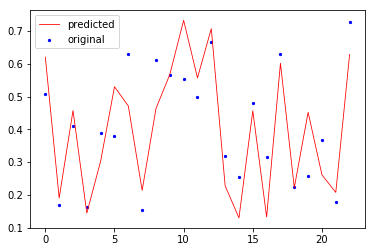

In [12]:
ypred = model_res.predict(xtest)
scores = model_res.evaluate(xtrain, ytrain)
print(scores)
print("MSE: %.4f" % mean_squared_error(ytest, ypred))
print("R-squared: %.4f" % r2_score(ytest,ypred))

x_ax = range(len(ypred))
plt.scatter(x_ax, ytest, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()